## <h1 align="center">Actividad Sesión 2: Agrupar datos textuales con el Modelo de Tópicos y el algoritmo Latent Dirichlet Allocation (LDA)</h3>

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<h2> Preámbulo</h2>
<p> Esta actividad se inspira de ejercicios disponibles en los recursos siguientes:<p>
<ul>
    <li>Biblioteca <a href="http://scikit-learn.org/stable/install.html/">SciKit-learn</a> de Python</li>
    <li>Código disponible en  <a href="https://github.com/lda-project/lda/">lda-project</a></li>
    <li>Basado en material preparado  por el Prof. Matthieu Vernier</li>
</ul>
<p> La actividad requiere el uso de Python 3.x y <a href="http://jupyter.org/install">Jupyter Notebook</a>. El código entregado fue probado con Python 3.9.7. Para saber cuál versión de Python usted está utilizando, ejecutar la celda siguiente (está información es importante cuando se necesitará instalar nuevos paquetes.)
</p>
</div>

In [51]:
import sys
print(sys.version)

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]



<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<h2>Objetivos de la actividad</h2>
<p>El <b>objetivo general</b> de esta actividad consiste en  explorar la estructura oculta de un conjunto de datos textuales.</p>
<p> Comenzaremos por utilizar un  algoritmo de clustering tradicional como Kmeans para explorar datos textuales, considerando la medida tf-idf por cada término presente en cada texto, para caracterizar los textos y construir distancias entre ellos.</p>
<p>En una segunda fase utilizaremos el <a href="https://drive.google.com/open?id=1rSQPJvRVj0V_IChzspQMRPNwlDTkHYHp"> Modelo Probabilista De Tópicos </a> para descubrir tópicos en los textos. Para ello se utilizará el algoritmo de asignación de tópicos latentes conocido como <a href= "https://drive.google.com/open?id=1BobImO3192hifZPLXowd14gryVAUzBPW">Latent Dirichlet Allocation (LDA)</a>. El enfoque es probabilista, por lo que el resultado del algoritmo es descubrir tópicos en los textos (el número de tópicos es definido por el analista) y asignar una distribución de probabilidad de tópicos en cada texto.</p>  Dependiendo del tamaño de los textos, es también posible agruparlos de acuerdo al tópico con mayor representación en cada uno, lo que permitirá comparar esta metodología con los algoritmos de clustering clásicos.</p> </div>
    
  

<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<p>Utilizaremos los mismos datos que en la sesión anterior.</p>   

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="contaminaciónacústica_chile_2018-01-01_2021-12-31.csv"
df = pd.read_csv(dataset)
df[:5]

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date,search
0,0,17785718.0,chile,emol,https://www.emol.com/noticias/Autos/2021/02/24...,Estudio advierte que la contaminación acústica...,La prestigiosa revista estadounidense The Atl...,2021-02-25,contaminación acústica
1,1,22416427.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,La contaminación acústica,"La contaminación acústica, según la Organizaci...",2021-06-15,contaminación acústica
2,2,261700.0,chile,biobiochile,https://www.biobiochile.cl/noticias/nacional/r...,Justicia ordena al municipio de Concepción fis...,La Municipalidad de Concepción deberá fiscaliz...,2020-07-02,contaminación acústica
3,3,22330373.0,chile,elllanquihue,https://www.ellanquihue.cl/impresa/2021/07/07/...,Contaminación acústica,"La contaminación acústica, según la Organizaci...",2021-07-07,contaminación acústica
4,4,13871464.0,chile,emol,https://www.emol.com/noticias/Nacional/2018/11...,Los siete puntos estratégicos de Santiago que ...,SANTIAGO.- El Ministerio del Medio Ambiente ...,2018-11-21,contaminación acústica


In [65]:
noticias = df[:88].text
print(len(noticias))
noticias[:10]

88


0    La prestigiosa revista estadounidense  The Atl...
1    La contaminación acústica, según la Organizaci...
2    La Municipalidad de Concepción deberá fiscaliz...
3    La contaminación acústica, según la Organizaci...
4    SANTIAGO.- El  Ministerio del Medio Ambiente  ...
5    La ministra del Medio Ambiente, Carolina Schmi...
6    La contaminación acústica es el enemigo invisi...
7    BOSTON.- El ruido en las ciudades es algo que ...
8    La contaminación acústica influye en la calida...
9     Haileen Piedra Coordinadora de Marketing Mide...
Name: text, dtype: object

In [53]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens




In [54]:
#Utilizando Kmeans y tf-idf para realizar un primer agrupamiento de las noticias
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

myStopWords=['gnl','=','$','+','a','e','o','u','y',' ','  ','   ','    ']
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, stop_words=myStopWords, ngram_range=(1,1))

X=vectorizer.fit_transform(noticias) 
X_term = vectorizer.get_feature_names()



In [64]:
import numpy as np
print(noticias[:1])

print(len(X_term))
print(X_term[:20])
print(X.shape)
print(X[:1])

0    La prestigiosa revista estadounidense  The Atl...
Name: text, dtype: object
6265
['-al', '-aunque', '-como', '-de', '-denunciado', '-en', '-es', '-frontera', '-integrado', '-junto', '-mantener', '-moz-background-size', '-no', '-o-background-size', '-plantear', '-por', '-producida', '-puntualizó-', '-que', '-ruido-']
(88, 6265)
  (0, 5612)	0.06420881539850011
  (0, 5321)	0.06420881539850011
  (0, 4715)	0.0255084160617998
  (0, 2269)	0.0413832284275956
  (0, 5054)	0.05877987306330863
  (0, 2800)	0.03210239020548982
  (0, 1879)	0.06420881539850011
  (0, 1233)	0.054927977176394326
  (0, 3996)	0.06420881539850011
  (0, 5683)	0.06420881539850011
  (0, 1856)	0.02986563302377793
  (0, 4397)	0.03914647124588371
  (0, 2248)	0.06420881539850011
  (0, 2018)	0.06420881539850011
  (0, 5657)	0.03478925428390558
  (0, 4058)	0.0340653255891039
  (0, 2346)	0.037230434051296744
  (0, 3402)	0.05194021460859401
  (0, 5497)	0.054927977176394326
  (0, 6147)	0.06420881539850011
  (0, 2136)	0.054927977176

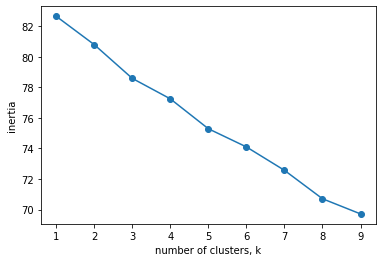

In [66]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


num_k = range(1, 10)
inertias = []

for k in num_k:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(X)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)


# Plot ks vs inertias
plt.plot(num_k, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(num_k)
plt.show()

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº1: Explore las clases TfidfVectorizer, CountVectorizer. ¿Qué rol cumplen? ¿Qué tratamiento preliminar de textos se ha hecho en este caso? ¿Qué rol cumple n_gram?</p>
</div>

In [67]:
from matplotlib.pylab import hist, show
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(X)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    cluster_words = np.array(terms)[order_centroids[i, :15]]
    print('Cluster {}: {}'.format(i, '-'.join(cluster_words)))



                                    

Top terms per cluster:
Cluster 0: proyecto-vecino-parque-empresa-camión-obra-comunidad-vara-sur-ambiental-senda-sector-zona-evento-impacto
Cluster 1: ruido-ciudad-bus-decibel-eléctrico-nivel-salud-transporte-persona-contaminación-santiago-vehículo-ambiente-db-acústico
Cluster 2: ballena-delfín-especie-cetáceo-hong-agua-kong-marino-azul-embarcación-zona-mamífero-población-mar-chiloé


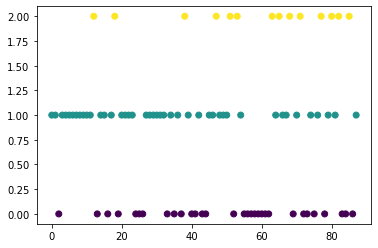

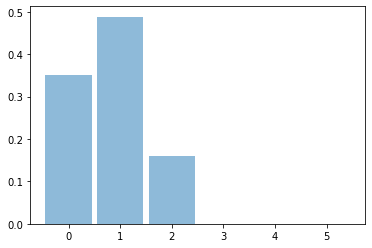

In [68]:
#Generando algunos gráficos de los resultados
labels = model.predict(X)
plt.scatter(range(88),labels,c=labels)
show()
hist(labels,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº2: Explore diversos valores en los parámetros de n_init y max_iter. ¿tienen influencia en los resultados? ¿Por qué? Describa e interprete los resultados.</p></div>

<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>En lo que sigue se construye un modelo probabilista de tópicos, considerando de 1 a 9 tópicos (para comparar con Kmeans
 y el algoritmo LDA estimado con el <a href="https://drive.google.com/open?id=1AoCcmg91Y1yRwM_Ox4Nvf6PGSQ9TybpE">, método de Bayes Variacional</a>, disponible como desarrollo en <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">sklearn-lda.</a></p> 
Previo a ello se utiliza la clase CountVectorizer y su función fit_transform que permite construir una matriz tf (DTM, Document-Term Matrix) que contiene la frecuencia de aparición de cada término del vocabulario en cada texto analizado. En la definición de la clase se especifica que:
<ol>
    <li>los términos que  aparecen sólo una vez en algún texto no serán considerados en el vocabulario (min_df=2)</li>
    <li> los términos que  aparecen en mas del 95% de los textos no serán considerados en el vocabulario (max_df=0.95)</li>
</ol></div>

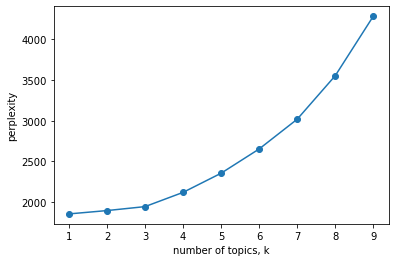

In [23]:
#Aplicando Modelos Probabilistas de Tópicos y LDA
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(noticias)
diccionario= tf_vectorizer.get_feature_names()


perp = []
for k in num_k:
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=k, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)
    #Cálculo de índice de ajuste de los datos
    perp.append(lda.perplexity(tf))

plt.plot(num_k, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity')
plt.xticks(num_k)
plt.show()

#print("\nTopics in LDA model:")
#print_top_words(lda, diccionario, 15)


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº3: Indage sobre la medida perplexity, ¿Cómo se interpreta el valor obtenido?
</p></div>

[[9.96229463e-01 1.75176502e-03 2.01877161e-03]
 [9.96158266e-01 1.87433847e-03 1.96739535e-03]
 [4.22189414e-03 4.09618794e-03 9.91681918e-01]
 [9.96536130e-01 1.68935363e-03 1.77451611e-03]
 [9.96960229e-01 1.47589578e-03 1.56387513e-03]
 [9.95586888e-01 2.13662458e-03 2.27648770e-03]
 [9.84709416e-01 7.15775968e-03 8.13282417e-03]
 [9.94375771e-01 2.64261085e-03 2.98161858e-03]
 [5.79827024e-01 6.71059382e-03 4.13462382e-01]
 [9.96551997e-01 1.68462449e-03 1.76337849e-03]
 [9.96551997e-01 1.68462449e-03 1.76337849e-03]
 [9.97320600e-01 1.32852282e-03 1.35087724e-03]
 [8.92487326e-01 5.45545884e-03 1.02057215e-01]
 [3.52659816e-03 3.41008880e-03 9.93063313e-01]
 [9.96465781e-01 1.70036235e-03 1.83385678e-03]
 [6.96362533e-01 3.43431502e-03 3.00203152e-01]
 [9.90727984e-01 4.38854831e-03 4.88346762e-03]
 [1.43299808e-01 3.81941022e-03 8.52880781e-01]
 [9.91094313e-01 3.99999743e-03 4.90568931e-03]
 [3.69253370e-03 3.60178432e-03 9.92705682e-01]
 [2.82413797e-03 2.73189268e-03 9.944439

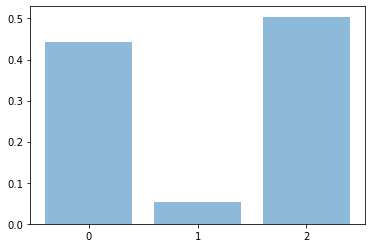

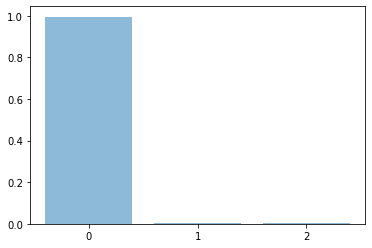

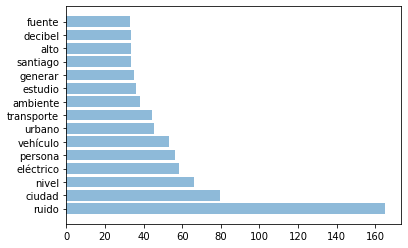

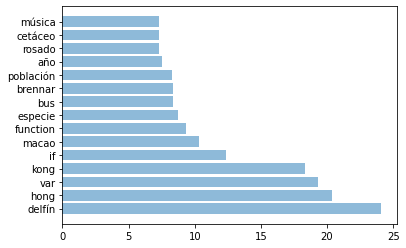

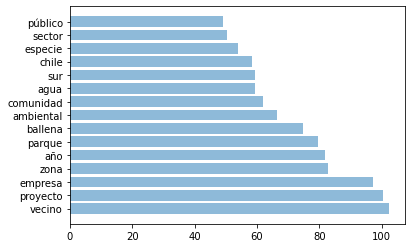

In [69]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import seaborn as sns

lda = LatentDirichletAllocation(n_components=true_k, max_iter=1000,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=0)
y=lda.fit_transform(tf)

print(y)
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
print(dist)

w=np.arange(0,true_k)
print(w)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()
#distribución de tópicos en el documento 51
plt.bar(w,height=y[50],alpha=0.5,tick_label=w)
show()


#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº4: Interprete estos gráficos. 
</p></div>

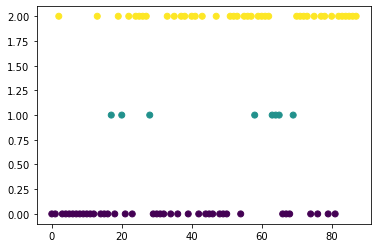

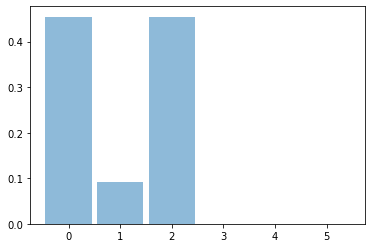

In [36]:
#calculando cluster en base al tópico mas frecuente
z=[]
for i in range(len(noticias)):
    z.append(np.argmax(y[i]))
plt.scatter(range(88),z,c=z)

#distribución de cluster de acuerdo al cálculo anterior
show()
hist(z,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº5: Explique si es posible comparar estos resultados con el agrupamiento con KMeans.
    
   ¿Cuáles serían los aspectos comparables? Interprete sus resultados.
</p></div>


<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>Una nueva estimación para algoritmo LDA considerando <a href="https://drive.google.com/open?id=1oSRRvG_W0UaH0l4o9f5ClEyWuGY1j-s0"> Gibbs Sampling</a>, disponible como desarrollo en <a href="https://github.com/lda-project/lda/">lda-project.</a></p> 
</div>

In [42]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()



In [45]:
prepared = pyLDAvis.sklearn.prepare(lda,tf,tf_vectorizer)
pyLDAvis.display(prepared)

In [39]:
import lda

model = lda.LDA(n_topics=true_k, n_iter=5000, alpha=0.1, eta=0.1, random_state=3)
model.fit(tf)  # model.fit_transform(X) is also available

topic_word = model.topic_word_  # model.components_ also works
n_top_words=10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(diccionario)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    


INFO:lda:n_documents: 88
INFO:lda:vocab_size: 2641
INFO:lda:n_words: 20370
INFO:lda:n_topics: 3
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -183378
INFO:lda:<10> log likelihood: -163474
INFO:lda:<20> log likelihood: -160572
INFO:lda:<30> log likelihood: -159059
INFO:lda:<40> log likelihood: -158684
INFO:lda:<50> log likelihood: -158465
INFO:lda:<60> log likelihood: -158091
INFO:lda:<70> log likelihood: -158202
INFO:lda:<80> log likelihood: -158042
INFO:lda:<90> log likelihood: -158003
INFO:lda:<100> log likelihood: -157729
INFO:lda:<110> log likelihood: -157908
INFO:lda:<120> log likelihood: -157741
INFO:lda:<130> log likelihood: -157493
INFO:lda:<140> log likelihood: -157309
INFO:lda:<150> log likelihood: -157317
INFO:lda:<160> log likelihood: -157448
INFO:lda:<170> log likelihood: -157531
INFO:lda:<180> log likelihood: -157191
INFO:lda:<190> log likelihood: -157335
INFO:lda:<200> log likelihood: -157464
INFO:lda:<210> log likelihood: -157414
INFO:lda:<220> log likelihood: -157

INFO:lda:<2050> log likelihood: -156459
INFO:lda:<2060> log likelihood: -156838
INFO:lda:<2070> log likelihood: -156773
INFO:lda:<2080> log likelihood: -156516
INFO:lda:<2090> log likelihood: -156966
INFO:lda:<2100> log likelihood: -156636
INFO:lda:<2110> log likelihood: -156596
INFO:lda:<2120> log likelihood: -156714
INFO:lda:<2130> log likelihood: -156695
INFO:lda:<2140> log likelihood: -156811
INFO:lda:<2150> log likelihood: -156652
INFO:lda:<2160> log likelihood: -156774
INFO:lda:<2170> log likelihood: -156784
INFO:lda:<2180> log likelihood: -156753
INFO:lda:<2190> log likelihood: -156826
INFO:lda:<2200> log likelihood: -156583
INFO:lda:<2210> log likelihood: -156801
INFO:lda:<2220> log likelihood: -156587
INFO:lda:<2230> log likelihood: -156889
INFO:lda:<2240> log likelihood: -156591
INFO:lda:<2250> log likelihood: -156545
INFO:lda:<2260> log likelihood: -156735
INFO:lda:<2270> log likelihood: -156894
INFO:lda:<2280> log likelihood: -156585
INFO:lda:<2290> log likelihood: -156670


INFO:lda:<4100> log likelihood: -157001
INFO:lda:<4110> log likelihood: -156724
INFO:lda:<4120> log likelihood: -156794
INFO:lda:<4130> log likelihood: -156730
INFO:lda:<4140> log likelihood: -156755
INFO:lda:<4150> log likelihood: -156836
INFO:lda:<4160> log likelihood: -156718
INFO:lda:<4170> log likelihood: -156707
INFO:lda:<4180> log likelihood: -156521
INFO:lda:<4190> log likelihood: -156661
INFO:lda:<4200> log likelihood: -156427
INFO:lda:<4210> log likelihood: -156698
INFO:lda:<4220> log likelihood: -156620
INFO:lda:<4230> log likelihood: -156595
INFO:lda:<4240> log likelihood: -156876
INFO:lda:<4250> log likelihood: -156703
INFO:lda:<4260> log likelihood: -156693
INFO:lda:<4270> log likelihood: -156601
INFO:lda:<4280> log likelihood: -156862
INFO:lda:<4290> log likelihood: -156665
INFO:lda:<4300> log likelihood: -156588
INFO:lda:<4310> log likelihood: -156659
INFO:lda:<4320> log likelihood: -156673
INFO:lda:<4330> log likelihood: -156672
INFO:lda:<4340> log likelihood: -156797


Topic 0: ballena especie agua zona marino población estudio año cetáceo delfín
Topic 1: vecino proyecto empresa parque comunidad año sector sur público zona
Topic 2: ruido ciudad transporte persona eléctrico nivel vehículo urbano generar salud


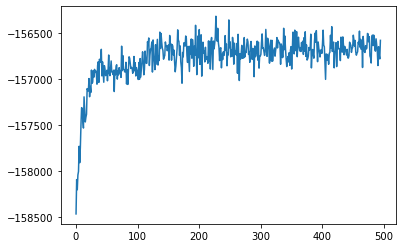

In [30]:
plt.plot(model.loglikelihoods_[5:])

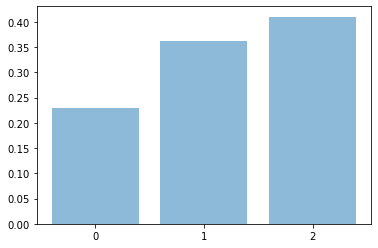

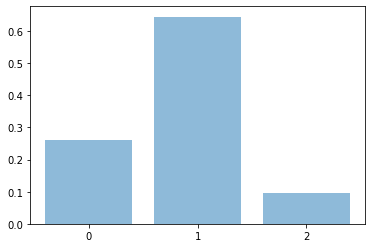

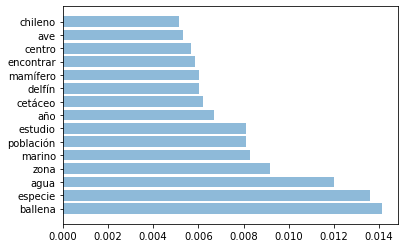

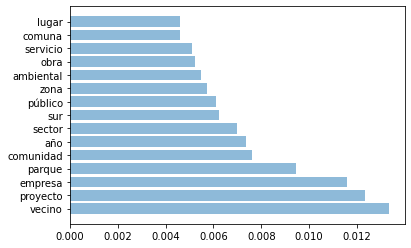

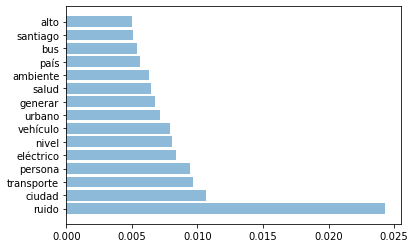

In [31]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show

y=model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
w=np.arange(0,true_k)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=y[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()





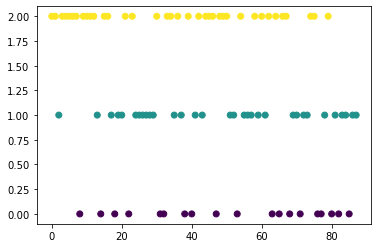

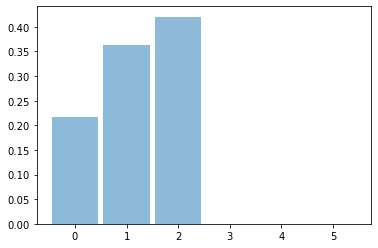

In [32]:
#calculando cluster en base al tópico mas frecuente
z=[]
for i in range(len(noticias)):
    z.append(np.argmax(y[i]))
plt.scatter(range(88),z,c=z)
show()

#distribución de cluster de acuerdo a la definición anterior
hist(z,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()



In [33]:
prepared = pyLDAvis.sklearn.prepare(model,tf,tf_vectorizer)
pyLDAvis.display(prepared)

/home/eliana/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarn

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº6: ¿Cómo se comparan estos resultados con los anteriores? ¿Qué puede decir de la convergencia de la estimación en este caso?
</p></div>